**Big Data Final Project:**
    
This project is about building a classification model which would read a review about a product in Flipkart and then predicts whether it has a good (rating > 3) or bad (rating <= 3) rating.

We have used the below dataset from Kaggle.
https://www.kaggle.com/datasets/kabirnagpal/flipkart-customer-review-and-rating 

Here, the rating is given between 1 to 5. First of all, we have converted this rating to binary i.e., if the rating is more than 3, then it is considered a good rating(1) otherwise if the rating is less than or equal to 3, then it is considered a bad rating(0).

After that, we have processed the reviews with NLP techniques like tokenization, stop words removal and build a tf-idf vectorizer at the end. Then, we passed this tf-idf vectorizer as input to the three machine learning models (Random Forest, LinearSVC and Logistic Regression) and do the predictions.

**Import Libraries**

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,col
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.sql.functions import when
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.sql.functions import regexp_replace, trim, col, lower
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler,StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [0]:
sparkSession = SparkSession.builder.appName('Reviews_Classifier').getOrCreate()

**Read Flipkart Reviews csv file**

In [0]:
df=sparkSession.read.load('/FileStore/tables/Flipkart_Reviews.csv',format='csv',header=True) 

Each row in the dataframe represents the actual review and its rating out of 5.

In [0]:
df.show(5,truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

**Data Pre-Processing**

In [0]:
# converting the rating column from string to integer
df = df.withColumn("rating", F.col("rating").astype(IntegerType()))

In [0]:
df.dtypes

Out[68]: [('review', 'string'), ('rating', 'int')]

If the rating is equal to or less than 3, the rating is bad(0) otherwise the rating is good(1).

In [0]:
matches = df["rating"].isin(0,1,2,3)
new_df = df.withColumn("rating", when(matches, 0).otherwise(1))

In [0]:
new_df.show(5,truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|review                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

**Data Visualization**

Out[71]: <AxesSubplot:>

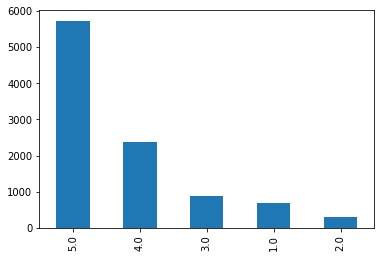

In [0]:
df.toPandas().rating.value_counts().plot.bar()

It is clear that more number of reviews have a rating of 5

Out[72]: <AxesSubplot:>

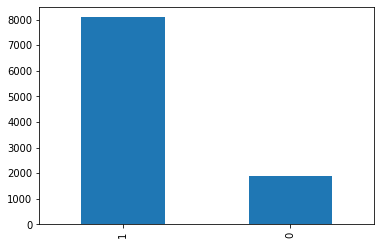

In [0]:
new_df.toPandas().rating.value_counts().plot.bar()

Now, after combining the rating of 1,2 and 3 to 0 and 4 and 5 to 1, it is clear that there are more number of positive ratings

First of all, let us remove the punctuations from the reviews. Because these punctuations wont give much value to the model

In [0]:
def removePunctuation(column):
    '''
    the column with the input text should be passed. It converts the text to lower case, strips leading and trailing spaces and remove punctuation
    '''
    return lower(trim(regexp_replace(column,'\\p{Punct}',''))).alias('punct_removed_review')

In [0]:
punct_removed_df = new_df.select(removePunctuation(col('review')))

In [0]:
punct_removed_df.show(5,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|punct_removed_review                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
+---------------------------------------

Now, let us convert each review in the entire dataframe into an array of individual words

In [0]:
tokenizer = Tokenizer(inputCol='punct_removed_review',outputCol='tokenized_review')

In [0]:
df_tokenized = tokenizer.transform(punct_removed_df)

In [0]:
df_tokenized.select('tokenized_review').show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tokenized_review                                                                                                                                                                                                                                                                                                                                                                                                                                      

As we can see, the tokenizer splits the entire review into an array of individual words. But there are lot of stop words like the, in, as etc. These stopwords would not give any value to the model. Therefore, let us remove those stop words.

In [0]:
stopwords_remover = StopWordsRemover(inputCol='tokenized_review',outputCol='non_stopwords')

In [0]:
stopwords_removed_df = stopwords_remover.transform(df_tokenized)

In [0]:
stopwords_removed_df.select('non_stopwords').show(5,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|non_stopwords                                                                                                                                                                                                                                                                                                                                                                                                                                |
+---------------------------------------------------------------------------------------------------------------------------------------

In [0]:
stopwords_removed_df.dtypes

Out[82]: [('punct_removed_review', 'string'),
 ('tokenized_review', 'array<string>'),
 ('non_stopwords', 'array<string>')]

Now, let us count the occurrences of each unique words by using Count Vectorizer.

In [0]:
count_vect = CountVectorizer(inputCol='non_stopwords',outputCol='count_vector')

In [0]:
count_vector_fitted = count_vect.fit(stopwords_removed_df)

In [0]:
count_vectored_df = count_vector_fitted.transform(stopwords_removed_df)

let us view the results of count vectorizer

In [0]:
count_vectored_df.select('count_vector').show(5,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|count_vector                                                                                                                                                                                                                                                                                                                                                                          |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Now let us calculate tf-idf i.e., Term Frequency - Inverse Document Frequency. It is a measure used to quantify the importance of a string in a document among the collection of documents

In [0]:
tfidf = IDF(inputCol='count_vector',outputCol='tf_idf_vector')

In [0]:
tfidf_fitted = tfidf.fit(count_vectored_df)

In [0]:
tfidf_df = tfidf_fitted.transform(count_vectored_df)

let us view the results of the TF-IDF vectorizer

In [0]:
tfidf_df.select('tf_idf_vector').show(5,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Now, let us merge the labels to the final tfidf_df dataframe using monotonically increasing id i.e., by having a common row id for each dataframes and then join them based on the id's and drop the rows that contain empty list of tokens.

In [0]:
tfidf_df_id = tfidf_df.withColumn("id", monotonically_increasing_id())
new_df_id = new_df.withColumn("id", monotonically_increasing_id())

In [0]:
final_df = tfidf_df_id.join(new_df_id, "id", "outer").drop("id")
final_df = final_df.na.drop()

In [0]:
final_df.show(5,truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Selecting only the features and the label and keep it as a seperate dataframe

In [0]:
input_data = final_df.select(['tf_idf_vector','rating'])

In [0]:
input_data.show(5)

+--------------------+------+
|       tf_idf_vector|rating|
+--------------------+------+
|(10728,[1,6,24,42...|     1|
|(10728,[0,2,4,5,1...|     1|
|(10728,[0,1,2,4,5...|     1|
|(10728,[0,2,3,4,9...|     1|
|(10728,[2,3,4,6,1...|     1|
+--------------------+------+
only showing top 5 rows



Train - Test split:
training data = 70%
test data = 30%

In [0]:
train_data, test_data = input_data.randomSplit([0.7,0.3],42)

Now, let us combine the input features (in our case, the tf-idf value) and pass it as input vector to the classification model

In [0]:
# Vector assembler is used to create a vector of input features

assembler = VectorAssembler(inputCols=['tf_idf_vector'],
                            outputCol="features")

**Model Construction**

First of all, let us try with the Random Forest classifier

**Random Forest Classifier**

In [0]:
# Train a Random Forest model.
rf_model = RandomForestClassifier(labelCol="rating", featuresCol="features", numTrees=10)

In [0]:
pipe = Pipeline(stages=[assembler,rf_model])

In [0]:
fit_model=pipe.fit(train_data)

In [0]:
# Store the results in a dataframe

results = fit_model.transform(test_data)

In [0]:
results.select(['rating','prediction']).show()

+------+----------+
|rating|prediction|
+------+----------+
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       1.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows



**Model Evaluation**

In [0]:
ACC_evaluator = MulticlassClassificationEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="accuracy")

In [0]:
accuracy = ACC_evaluator.evaluate(results)

In [0]:
print("The accuracy of the Random Forest classifier model is {}".format(accuracy))

The accuracy of the Random Forest classifier model is 0.81436919903747


The Random Forest Classifier performed reasonably well with an accuracy of 81.43%. 

Let us try to improve the accuracy by trying out different models.

Now, let us build a Linear Support Vector Classifier

**Linear SVC**

In [0]:
# Create an object for the Linear SVC model

svc_model = LinearSVC(labelCol='rating')

In [0]:
pipe = Pipeline(stages=[assembler,svc_model])

In [0]:
fit_model=pipe.fit(train_data)

In [0]:
# Store the results in a dataframe

results = fit_model.transform(test_data)

In [0]:
results.select(['rating','prediction']).show()

+------+----------+
|rating|prediction|
+------+----------+
|     1|       1.0|
|     1|       1.0|
|     1|       0.0|
|     0|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       0.0|
|     1|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       1.0|
|     1|       1.0|
|     1|       0.0|
|     1|       1.0|
|     1|       0.0|
|     1|       1.0|
|     0|       1.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows



**Model Evaluation**

In [0]:
ACC_evaluator = MulticlassClassificationEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="accuracy")

In [0]:
accuracy = ACC_evaluator.evaluate(results)

In [0]:
print("The accuracy of the Linear SVC model is {}".format(accuracy))

The accuracy of the Linear SVC model is 0.8466827088346511


print the confusion matrix

In [0]:
y_true = results.select("rating")
y_true = y_true.toPandas()

y_pred = results.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

Out[114]: array([[ 303,  237],
       [ 209, 2160]])

The Linear Support Vector Classifier performed well in predicting the rating by achieving an accuracy of 84.66%.

Area under the ROC

In [0]:
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='rating',metricName='areaUnderROC')

In [0]:
AUC = AUC_evaluator.evaluate(results)

In [0]:
print("The area under the curve is {}".format(AUC))

The area under the curve is 0.7364441161296374


A roughly 73% area under ROC denotes the model has performed reasonably well in predicting whether a review rating is good or bad.

Next, let us build a Logistic Regression model

**Logistic Regression**

In [0]:
lr_model = LogisticRegression(labelCol='rating')

In [0]:
pipe = Pipeline(stages=[assembler,lr_model])

In [0]:
fit_model=pipe.fit(train_data)

In [0]:
# Store the results in a dataframe

results = fit_model.transform(test_data)

In [0]:
results.select(['rating','prediction']).show()

+------+----------+
|rating|prediction|
+------+----------+
|     1|       0.0|
|     1|       1.0|
|     1|       1.0|
|     0|       1.0|
|     1|       1.0|
|     1|       0.0|
|     0|       0.0|
|     1|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       1.0|
|     1|       1.0|
|     1|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     0|       1.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows



**Model Evaluation**

In [0]:
ACC_evaluator = MulticlassClassificationEvaluator(
    labelCol="rating", predictionCol="prediction", metricName="accuracy")

In [0]:
accuracy = ACC_evaluator.evaluate(results)

In [0]:
print("The accuracy of the Logistic Regression model is {}".format(accuracy))

The accuracy of the Logistic Regression model is 0.8209006531454108


print the confusion matrix

In [0]:
y_true = results.select("rating")
y_true = y_true.toPandas()

y_pred = results.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

Out[126]: array([[ 305,  235],
       [ 286, 2083]])

The Logistic Regression model performed really good with an accuracy of 82.09%.

Area under the ROC

In [0]:
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='rating',metricName='areaUnderROC')

In [0]:
AUC = AUC_evaluator.evaluate(results)

In [0]:
print("The area under the curve is {}".format(AUC))

The area under the curve is 0.7220443850350985


A 72% area under ROC denotes the model has performed reasonably well in predicting whether a review rating is good or bad.

Out of three models, the Linear Support Vector Classifier provides higher accuracy of 84.66%.